# Differences in behaviour of Rt Profile for Different Infectiousness Levels of Imported Cases

The aim of this notebook is to show how different values the epsilon parameter can affect the outcome of the epidemic. This effect is studied through the behaviour of the time-dependent reproduction number trajectory. Epsilon represents the proportionality constant of the reproduction number for imported cases with respect to its analog for local ones. For this analysis we will use an Rt profile from real data from Hong Kong, China with an assumed infectioness of imported cases equal to that of the local ones (i.e. epsilon = 1).

This Rt profile will then be used together with synthetically generated imported cases to produce local incidences for a given 'true' value of epsilon. We will proceed to infer the Rt profile for both the true value of epsilon and for epsilon = 1 (for the most common scenario when no distinguishing is made between the imported and the local cases).

In [1]:
# Import libraries
import numpy as np
import branchpro
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import scipy.stats
import datetime

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


In [2]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T

In [3]:
# Select length of timeline for the analysis
num_timepoints = 50

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

### A Reproduction Number trajectory inferred from a world example data is used for realistic results

In [4]:
# Read Rt trajectory
rt_file = 'HK-Rt-profile'
path = os.path.join('../data_library/rt_profile', '{}.csv'.format(rt_file))
rt_profile = pd.read_csv(path)

### Imported Cases Counts are produced by sampling from a Poisson distribution with mean λ

In [5]:
# Build the imported cases
lambdas = [1, 10, 20]
num_sim_imported = 10

imported_times = np.arange(1,(num_timepoints+1))
all_imported_cases = []

for ic_mean in lambdas:
    sample_imported_cases = []

    # Multiple samples of imported cases data
    for sim in range(num_sim_imported):
        sample_imported_cases.append(scipy.stats.poisson.rvs(ic_mean, size=num_timepoints))

    all_imported_cases.append(np.vstack(sample_imported_cases))

### Generate Local Incidences using the previously generated Imported Cases, according to the read-in Rt profile

In [6]:
# Construct LocImpBranchProModel object
epsilon_values = [0.25, 1, 2.5]
tau = 6
R_t_start = tau+1

# Set fixed parameters for the instantiaiton of the model
r_profile = rt_profile['Mean'].values.tolist()
r_start_times = rt_profile['Time Points'].values.tolist()

initial_r = r_profile[0]
si = np.median(serial_intervals, axis=0)
parameters = 0 # initial number of cases

all_local_cases = []
num_sim_local = 10

for _, epsilon in enumerate(epsilon_values):
    lam_sample_local_cases = []
    for l, lam in enumerate(lambdas):
        m = branchpro.LocImpBranchProModel(initial_r, si, epsilon)

        m.set_r_profile(r_profile, r_start_times)

        ind_imp_sample_local_cases = []
        for imported_cases in all_imported_cases[l]:
            m.set_imported_cases(start_times, imported_cases)

            sample_local_cases = []
            for sim in range(num_sim_local):
                sample_local_cases.append(m.simulate(parameters, times)[1:])

            ind_imp_sample_local_cases.append(np.vstack(sample_local_cases))

        lam_sample_local_cases.append(ind_imp_sample_local_cases)
    
    all_local_cases.append(lam_sample_local_cases)

In [19]:
all_local_cases[0][0][0][0].shape

(50,)

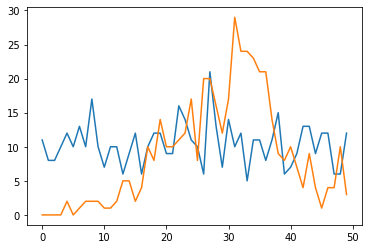

In [20]:
import matplotlib.pyplot as plt

plt.plot(all_imported_cases[0][0])
plt.plot(all_local_cases[0][0][0][0])

In [21]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=all_local_cases[0][0][0][0],
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=all_imported_cases[0][0],
        name='Imported Cases'
    )
)

# Add axis labels
fig.update_layout(
    template='simple_white',
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

# fig.write_image('HK-cases.pdf')
fig.show()

### Inference of the Rt profile for the true choice of ϵ and for the baseline ϵ = 1

In [7]:
# Define the divergence function between the two posterior summary dataframes
def post_divergence(df1, df2):
    return np.sum(np.absolute(df1['Mean']-df2['Mean']))

In [8]:
# Inference R_t profile using the LocImpBranchProPosterior
a = 1
b = 0.2

# Run comparative inferences for different values of epsilon and lambda
difference = np.empty((len(epsilon_values), len(lambdas)))

for _, epsilon in enumerate(epsilon_values):
    for l, lam in enumerate(lambdas):
        point_difference = []
        for i, imported_cases in enumerate(all_imported_cases[l]):
            for locally_infected_cases in all_local_cases[_][l][i]:
                # Transform our incidence data into pandas dataframes
                inc_data = pd.DataFrame(
                    {
                        'Time': start_times,
                        'Incidence Number': locally_infected_cases
                    }
                )

                imported_inc_data = pd.DataFrame(
                    {
                        'Time': start_times,
                        'Incidence Number': imported_cases
                    }
                )

                # Run inference for the true value of epsilon
                inference_true = branchpro.LocImpBranchProPosteriorMultSI(
                    inc_data=inc_data,
                    imported_inc_data=imported_inc_data,
                    epsilon=epsilon,
                    daily_serial_intervals=serial_intervals,
                    alpha=a,
                    beta=b)

                inference_true.run_inference(tau=tau)
                intervals_true = inference_true.get_intervals(central_prob=0)

                # Run inference for the baseline value of epsilon = 1
                inference_baseline = branchpro.LocImpBranchProPosteriorMultSI(
                    inc_data=inc_data,
                    imported_inc_data=imported_inc_data,
                    epsilon=1,
                    daily_serial_intervals=serial_intervals,
                    alpha=a,
                    beta=b)

                inference_baseline.run_inference(tau=tau)
                intervals_baseline = inference_baseline.get_intervals(central_prob=0)

                # Compute divergence between the two posteriors
                point_difference.append(post_divergence(intervals_true, intervals_baseline))

        difference[_, l] = np.mean(np.array(point_difference))

### Compute heatmap of the divergence between posteriors fitted the true and baseline ϵ for different values of ϵ and λ

In [9]:
fig = go.Figure()

# Plot heatmap
fig.add_trace(
    go.Heatmap(
        x=lambdas,
        y=epsilon_values,
        z=difference,
        type = 'heatmap',
        coloraxis= 'coloraxis'
    ),
)

# Add axis labels
fig.update_xaxes(type='category', title_text='λ')
fig.update_yaxes(type='category', title_text='ϵ')

fig.update_layout(
    boxmode='group',
    height=500,
    width=500,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black'),
    yaxis=dict(
        linecolor='black'),
    coloraxis=dict(colorscale='Viridis'))

fig.write_image('Heatmap.pdf')
fig.show()